In [1]:
# !pip install kaggle
# !pip install numpy
# !pip install pandas
# !pip install graphviz

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random as rd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import time

rd.seed(1)

In [3]:
# load training set
train = pd.read_csv('../../Datasets/train.csv')

# load test set
test = pd.read_csv('../../Datasets/test.csv')

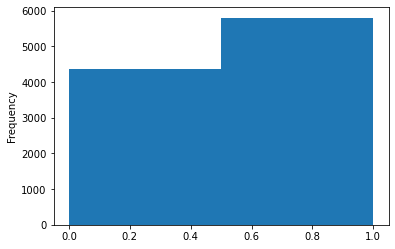

In [4]:
# relatively evenly distributed data set, slightly imbalanced
train['Decision'].astype(int).plot.hist(bins=2)
plt.savefig('decision_frequency', dpi=100)

In [5]:
# move decision to be last column
train = train[[c for c in train if c not in ['Decision']] + ['Decision']]

# get copy of features and labels, saving features without Decision column
X_train = train.iloc[:,1:-1]
y_train = train.iloc[:,-1]
X_test = test.iloc[:,1:]

In [6]:
# # explore the raw data
X_train.select_dtypes('object').apply(pd.Series.nunique,axis=0)

Driving_to          3
Passanger           4
Weather             3
Time                5
Coupon              5
Coupon_validity     2
Gender              2
Age                 8
Maritalstatus       5
Education           6
Occupation         25
Income              9
dtype: int64

In [7]:
# see if the categorical data are unbalanced
X_train['Age'].value_counts()

21         2136
26         2014
31         1609
50plus     1451
36         1104
41          865
46          563
below21     442
Name: Age, dtype: int64

In [8]:
# drop occupation because it's too many categories and accoding to the correlation they are not very important
# add in if the person is retired or unemployed, since those matter in the correlatiolns
X_train['Employed'] = X_train['Occupation'] == 'Unemployed'
X_train['Retired'] = X_train['Occupation'] == 'Retired'
X_train['Employed'] = X_train['Employed'].map({False: 0, True: 1})
X_train['Retired'] = X_train['Retired'].map({False: 0, True: 1})
X_train = X_train.drop(['Occupation'], axis=1)

X_test['Employed'] = X_test['Occupation'] == 'Unemployed'
X_test['Retired'] = X_test['Occupation'] == 'Retired'
X_test['Employed'] = X_test['Employed'].map({False: 0, True: 1})
X_test['Retired'] = X_test['Retired'].map({False: 0, True: 1})
X_test = X_test.drop(['Occupation'], axis=1)

In [9]:
X_train[X_train.isnull().any(axis=1)]

,Driving_to,Passanger,Weather,Temperature,Time,Coupon,Coupon_validity,Gender,Age,Maritalstatus,...,Income,Bar,Coffeehouse,Carryaway,Restaurantlessthan20,Restaurant20to50,Direction_same,Distance,Employed,Retired
24,Home,Alone,Sunny,80,6PM,Restaurant(20-50),1d,Female,46,Married partner,...,$100000 or More,0.0,3.0,3.0,2.0,NaN,1,1,0,0
58,Work,Alone,Sunny,80,7AM,Carry out & Take away,2h,Male,21,Single,...,$50000 - $62499,4.0,2.0,NaN,3.0,1.0,1,1,0,0
66,No Urgent Place,Partner,Rainy,55,10AM,Carry out & Take away,2h,Female,26,Married partner,...,$87500 - $99999,2.0,1.0,NaN,1.0,1.0,0,1,1,0
77,Home,Alone,Snowy,30,10PM,Coffee House,2h,Female,36,Married partner,...,$37500 - $49999,1.0,NaN,2.0,2.0,2.0,0,2,0,0
99,Work,Alone,Rainy,55,7AM,Bar,1d,Male,41,Married partner,...,$37500 - $49999,NaN,1.0,2.0,3.0,2.0,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10057,Home,Alone,Sunny,80,6PM,Carry out & Take away,2h,Male,26,Unmarried partner,...,$25000 - $37499,1.0,NaN,2.0,0.0,0.0,1,2,0,0
10079,No Urgent Place,Alone,Sunny,80,10AM,Restaurant(<20),2h,Female,31,Single,...,$75000 - $87499,NaN,1.0,4.0,2.0,1.0,0,1,0,0
10154,Home,Alone,Rainy,55,6PM,Bar,1d,Male,26,Married partner,...,$12500 - $24999,2.0,3.0,2.0,2.0,NaN,0,3,0,0
10158,No Urgent Place,Friend(s),Sunny,80,6PM,Restaurant(<20),1d,Female,31,Single,...,$37500 - $49999,1.0,1.0,3.0,NaN,1.0,0,2,0,0


In [10]:
X_train.isnull().sum(axis=0)

Driving_to                0
Passanger                 0
Weather                   0
Temperature               0
Time                      0
Coupon                    0
Coupon_validity           0
Gender                    0
Age                       0
Maritalstatus             0
Children                  0
Education                 0
Income                    0
Bar                      93
Coffeehouse             182
Carryaway               125
Restaurantlessthan20    105
Restaurant20to50        151
Direction_same            0
Distance                  0
Employed                  0
Retired                   0
dtype: int64

In [11]:
# impute the missing values as 0's
# X_train = X_train.replace(np.nan, 0.0)
# X_test = X_test.replace(np.nan, 0.0)

In [12]:
# create dummies for categorical variables
X_train_dums = pd.get_dummies(X_train, drop_first = True)
X_test_dums = pd.get_dummies(X_test, drop_first = True)

In [13]:
X_train_dums.shape

(10184, 52)

In [14]:
# explore more with dummies
X_train_dums[X_train_dums.columns[25]].describe()

count    10184.000000
mean         0.220051
std          0.414301
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Coupon_Restaurant(<20), dtype: float64

In [15]:
# describe correlations between features and decision
correlations = X_train_dums.join(train['Decision']).corr()['Decision'].sort_values()
print(correlations.head(15))
print()
print(correlations.tail(15))

Coupon_validity_2h                                 -0.126076
Distance                                           -0.115933
Coupon_Restaurant(20-50)                           -0.091576
Coupon_Coffee House                                -0.086640
Weather_Snowy                                      -0.084246
Time_7AM                                           -0.074646
Driving_to_Work                                    -0.074646
Time_10PM                                          -0.058723
Age_50plus                                         -0.052171
Children                                           -0.051322
Income_$75000 - $87499                             -0.046798
Retired                                            -0.046042
Education_Graduate degree (Masters or Doctorate)   -0.041933
Maritalstatus_Married partner                      -0.038675
Passanger_Kid(s)                                   -0.036133
Name: Decision, dtype: float64

Education_Some college - no degree    0.039721
Restau

In [16]:
# feature names
feature_dum_names = X_train_dums.columns

# initialize scaler and imputer, for normalizing and missing data
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
scaler = MinMaxScaler(feature_range = (0, 1))

# fit training
imputer.fit(X_train_dums)
X_train_dums = imputer.transform(X_train_dums)
X_test_dums = imputer.transform(X_test_dums)

# repeat with the scaler
scaler.fit(X_train_dums)
X_train_dums = pd.DataFrame(scaler.transform(X_train_dums), columns = feature_dum_names)
X_test_dums = pd.DataFrame(scaler.transform(X_test_dums), columns = feature_dum_names)

Time it took to tune alpha (in seconds): 33.965436935424805
The maximum mean accuracy I got (0.7037503542708191) was with alpha = 0.00045 (std = 0.015611079254327994).



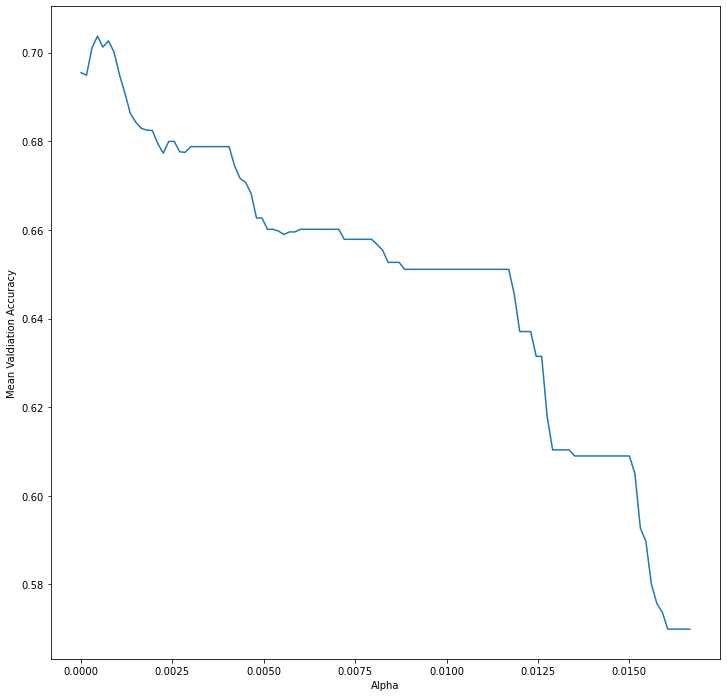

<Figure size 432x288 with 0 Axes>

In [17]:
# Decision Trees using sklearn
from sklearn import tree, metrics, datasets
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate

# 10-fold cross-validation to tune alpha first
alphas = np.arange(0.0,0.0167,0.00015)
alpha_accs = np.zeros((len(alphas),10,))

kf = KFold(n_splits = 10)
count = 0

start = time.time()

for train_index, validation_index in kf.split(X_train):
    # split training set
    X_t, X_v = X_train_dums.iloc[train_index,:], X_train_dums.iloc[validation_index,:]
    y_t, y_v = y_train.iloc[train_index], y_train.iloc[validation_index]
    for i in range(len(alphas)):
        # train on given depth
        clf = tree.DecisionTreeClassifier(ccp_alpha = alphas[i], max_depth=8)
        clf.fit(X_t, y_t)
        pred = clf.predict(X_v)

        # get accuracy for this depth on this fold
        alpha_accs[i][count] = metrics.accuracy_score(pred, y_v)
    
    count += 1

end = time.time()
print("Time it took to tune alpha (in seconds): " + str(end - start))
    
mean_accs = alpha_accs.mean(axis=1)
std_accs = alpha_accs.std(axis=1)
max_index = np.argmax(mean_accs)

print("The maximum mean accuracy I got ({}) was with alpha = {} (std = {}).\n".format(mean_accs[max_index], alphas[max_index], std_accs[max_index]))

plt.figure(figsize=(12,12))
plt.plot(alphas, mean_accs)
plt.xlabel('Alpha')
plt.ylabel('Mean Valdiation Accuracy')
plt.show()
plt.savefig('decision_tree_alpha_tune')

# save best alpha
alpha = alphas[max_index]

Time it took to tune depth (in seconds): 2.4190940856933594
The maximum mean accuracy I got (0.7055189127597263) was with depth = 9 (std = 0.01226856805684159).



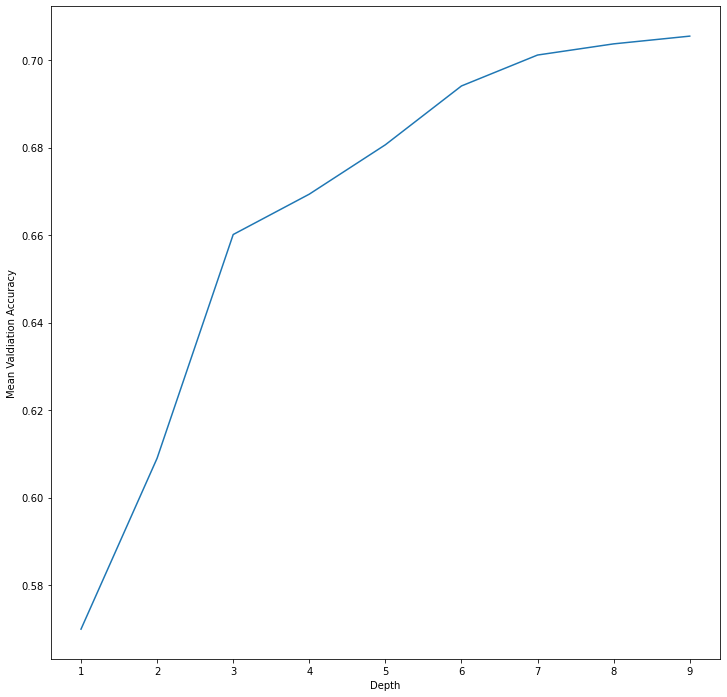

<Figure size 432x288 with 0 Axes>

In [18]:
# 10-fold cross-validation to tune max_depth next
depths = range(1,10)
depth_accs = np.zeros((len(depths),10,))

kf = KFold(n_splits = 10)
count = 0

start = time.time()

for train_index, validation_index in kf.split(X_train):
    # split training set
    X_t, X_v = X_train_dums.iloc[train_index,:], X_train_dums.iloc[validation_index,:]
    y_t, y_v = y_train.iloc[train_index], y_train.iloc[validation_index]
    for d in depths:
        # train on given depth
        clf = tree.DecisionTreeClassifier(ccp_alpha = alpha, max_depth=d)
        clf.fit(X_t, y_t)
        pred = clf.predict(X_v)

        # get accuracy for this depth on this fold
        depth_accs[d-1][count] = metrics.accuracy_score(pred, y_v)
    
    count += 1

mean_accs = depth_accs.mean(axis=1)
std_accs = depth_accs.std(axis=1)
max_index = np.argmax(mean_accs)

end = time.time()
print("Time it took to tune depth (in seconds): " + str(end - start))

print("The maximum mean accuracy I got ({}) was with depth = {} (std = {}).\n".format(mean_accs[max_index], depths[max_index], std_accs[max_index]))

plt.figure(figsize=(12,12))
plt.plot(depths, mean_accs)
plt.xlabel('Depth')
plt.ylabel('Mean Valdiation Accuracy')
plt.show()
plt.savefig('decision_tree_depth_tune')

# save best depth
depth = depths[max_index]

In [19]:
start = time.time()

clf = tree.DecisionTreeClassifier(ccp_alpha = alpha, max_depth=depth)
clf.fit(X_train_dums, y_train)

end = time.time()
print("Time it took to fit Decision Tree model (in seconds): " + str(end - start))

train_preds = clf.predict(X_train_dums)
print("Accuracy on training set: " + str(metrics.accuracy_score(train_preds, y_train)))

train_probs = clf.predict_proba(X_train_dums)
train_decisions = [prob[1] for prob in train_probs]

Time it took to fit Decision Tree model (in seconds): 0.04830121994018555
Accuracy on training set: 0.7265318146111548


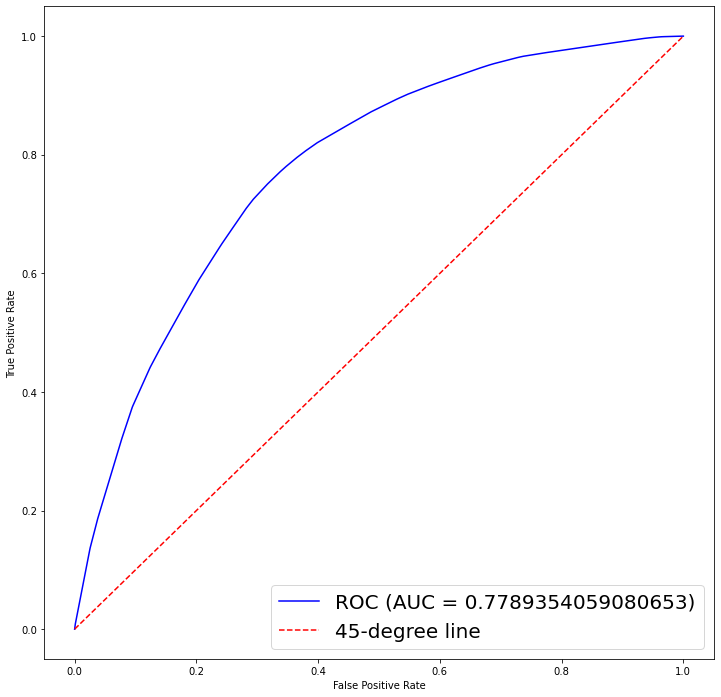

<Figure size 432x288 with 0 Axes>

In [20]:
# graph roc curve for the training set
fpr, tpr, ts = metrics.roc_curve(np.array(y_train), np.array(train_decisions))
plt.figure(figsize=(12,12))
plt.plot(fpr, tpr, color='b', label="ROC (AUC = {})".format(metrics.auc(fpr,tpr)))
plt.plot([0,1],[0,1], color='r', linestyle='--',label='45-degree line')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right', prop={'size':20})
plt.show()
plt.savefig('decision_tree_roc_auc')

This tree looks like:


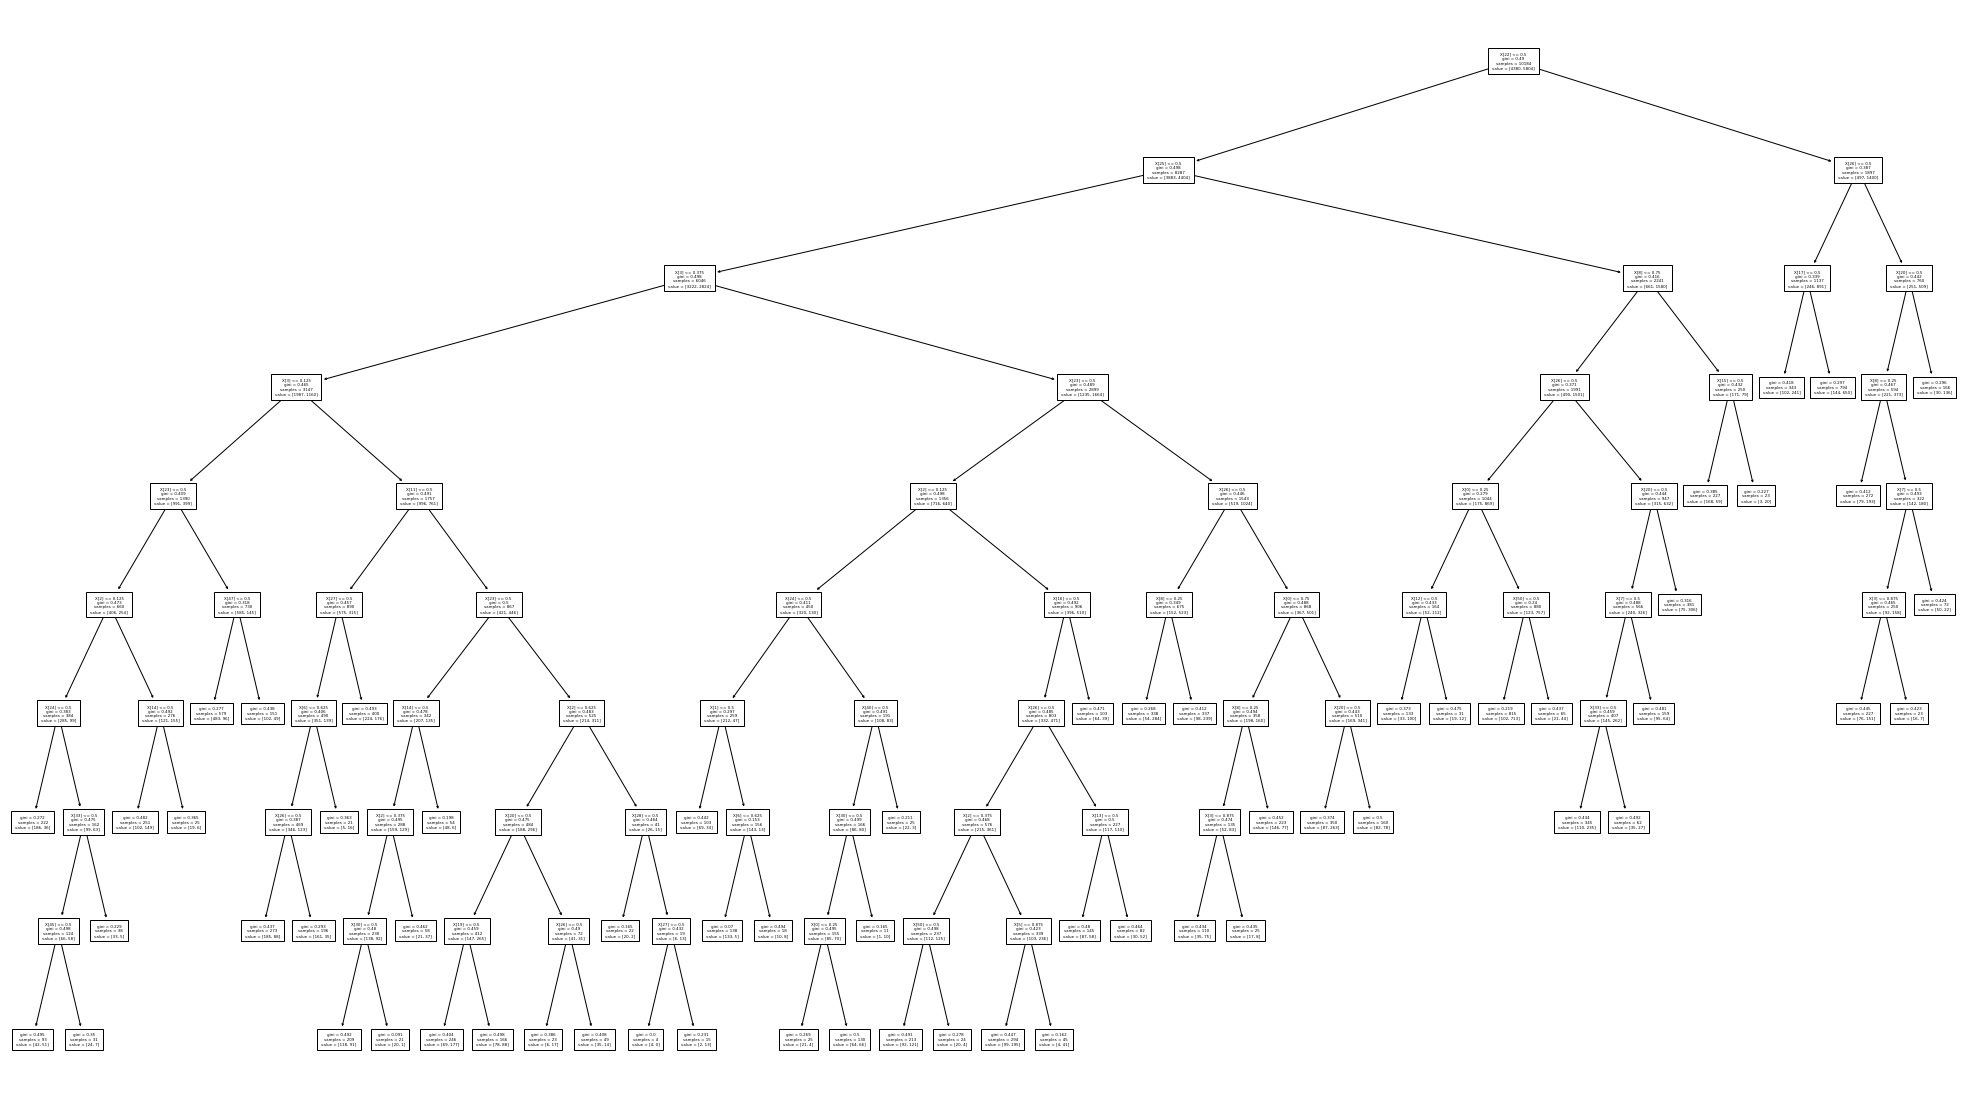

In [21]:
# display tree
plt.figure(figsize=(35,20))
tree.plot_tree(clf, fontsize=4)
plt.savefig('tree_high_dpi', dpi=200)
print("This tree looks like:")

In [22]:
# predict decision tree using test values
y_pred_1 = clf.predict(X_test_dums)
pred1 = pd.concat([test['id'],pd.Series(y_pred_1)], axis=1)
pred1 = pred1.rename(columns={0:'Decision'})
pred1.to_csv('decision_tree_preds.csv',index=False)

<div style = "background-color: #000000; height: 10px; width: 100%">

In [23]:
# Gradient Boosting Classifier with sklearn (similar to stumps from HW2)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

start = time.time()

# takes about 50 minutes to run with this split of 10 settings--if
# I reduce to 3 settings each then it takes about 6 minutes

# use grid search CV, to first tune learning rate and n_estimators
model = GradientBoostingClassifier()
learning_rates = np.arange(0.25,0.35,0.01)
n_estimators = range(550, 650, 10)
param_grid = dict(learning_rate=learning_rates,n_estimators=n_estimators)
kf = KFold(n_splits = 10)
grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1, cv=kf)
grid_result = grid_search.fit(X_train_dums, y_train)

end = time.time()
print("Time it took to grid search and tune n_estimators and learning rate (in seconds): " + str(end - start))
print("Best mean accuracy was {} using learning rate = {} and {} estimators".format(grid_result.best_score_, grid_result.best_params_['learning_rate'], grid_result.best_params_['n_estimators']))


Time it took to grid search and tune n_estimators and learning rate (in seconds): 2591.048903942108
Best mean accuracy was 0.7566766794364829 using learning rate = 0.31000000000000005 and 590 estimators


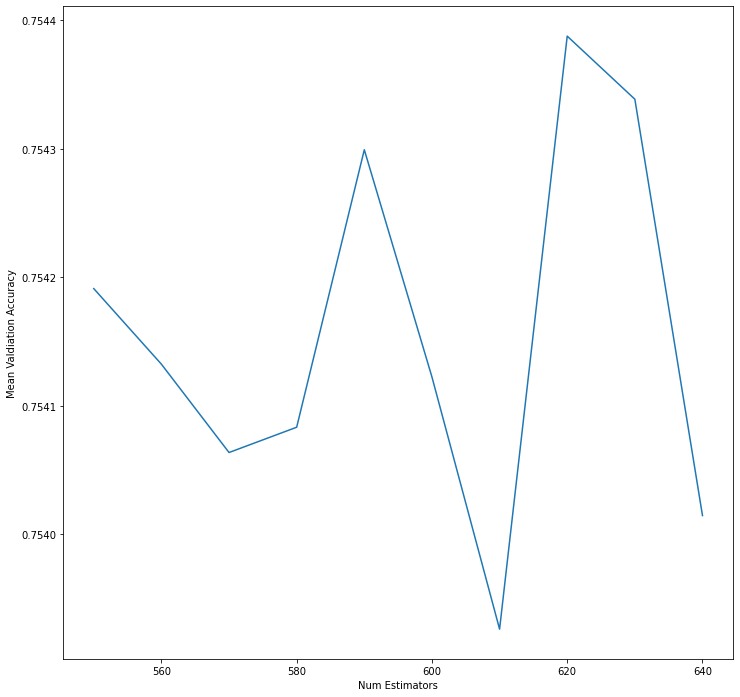

<Figure size 432x288 with 0 Axes>

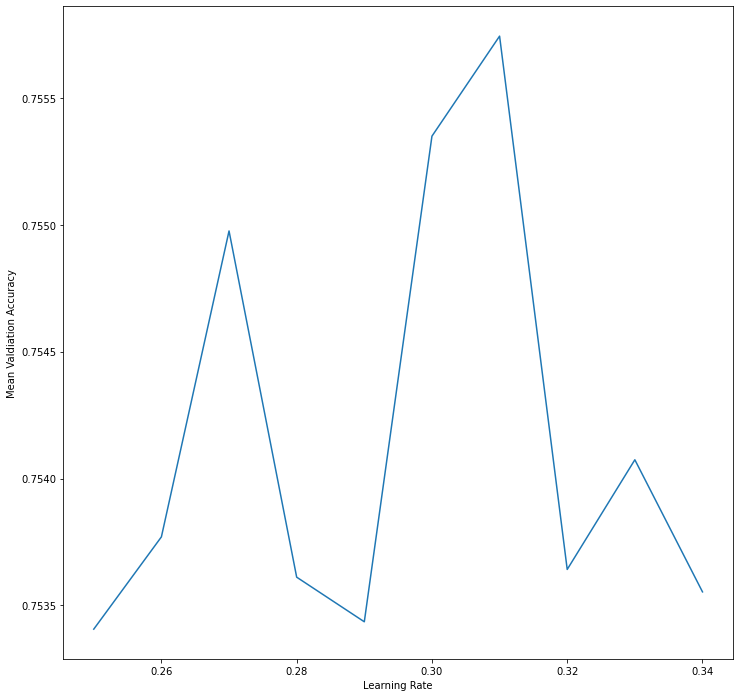

<Figure size 432x288 with 0 Axes>

In [24]:
# save the best learning rate and n_estimators
N = grid_result.best_params_['n_estimators']
rate = grid_result.best_params_['learning_rate']

# average accuracy on each validation
mean_accs = np.array(grid_result.cv_results_['mean_test_score']).reshape(10,10)

# average over opposite parameter, for simplicity
mean_n_estimators = np.average(mean_accs, axis=0)
mean_l_rate = np.average(mean_accs, axis=1)

plt.figure(figsize=(12,12))
plt.plot(n_estimators, mean_n_estimators)
plt.xlabel('Num Estimators')
plt.ylabel('Mean Valdiation Accuracy')
plt.show()
plt.savefig('boosting_num_ests_tune')

plt.figure(figsize=(12,12))
plt.plot(learning_rates, mean_l_rate)
plt.xlabel('Learning Rate')
plt.ylabel('Mean Valdiation Accuracy')
plt.show()
plt.savefig('boosting_l_rate_tune')

In [25]:
start = time.time()

# use grid search CV, to now tune depth
model = GradientBoostingClassifier(learning_rate = rate, n_estimators = N)
depths = range(2,7)
param_grid = dict(max_depth = depths)
kf = KFold(n_splits = 10)
grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1, cv=kf)
grid_result = grid_search.fit(X_train_dums, y_train)

end = time.time()
print("Time it took to grid search and tune n_estimators and learning rate (in seconds): " + str(end - start))
print("Best mean accuracy, given the learning rate and number of estimators, was {} using depth = {}".format(grid_result.best_score_, grid_result.best_params_['max_depth']))


Time it took to grid search and tune n_estimators and learning rate (in seconds): 190.7747299671173
Best mean accuracy, given the learning rate and number of estimators, was 0.7587396442060574 using depth = 4


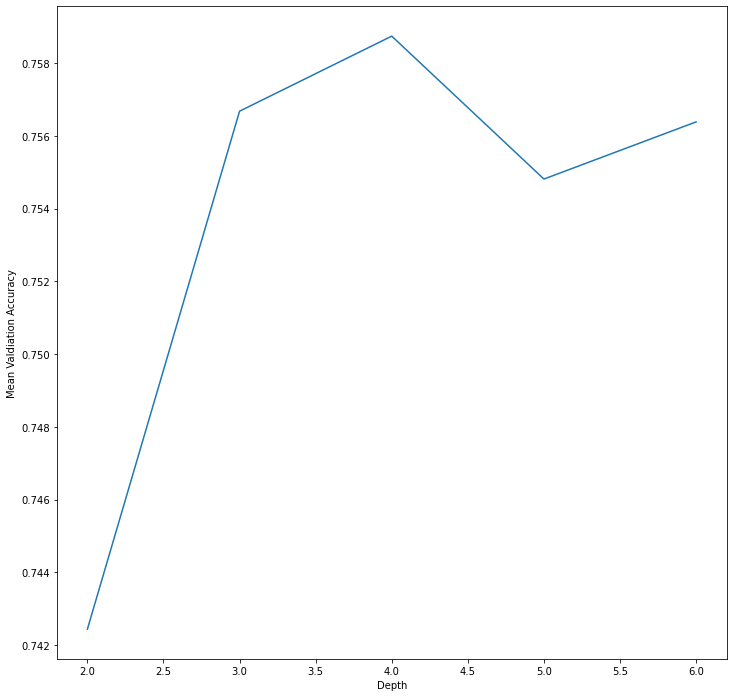

<Figure size 432x288 with 0 Axes>

In [26]:
# save the best learning rate and n_estimators
depth = grid_result.best_params_['max_depth']

# average accuracy on each validation
mean_depth = np.array(grid_result.cv_results_['mean_test_score'])

plt.figure(figsize=(12,12))
plt.plot(depths, mean_depth)
plt.xlabel('Depth')
plt.ylabel('Mean Valdiation Accuracy')
plt.show()
plt.savefig('boosting_depth_tune')

In [27]:
start = time.time()

clf = GradientBoostingClassifier(learning_rate = rate, n_estimators = N, max_depth = depth, random_state = rd.randint(0,100))
clf.fit(X_train_dums, y_train)

end = time.time()
print("Time it took to fit Gradient Boosting model (in seconds): " + str(end - start))

train_preds = clf.predict(X_train_dums)
print("Accuracy on training set: " + str(metrics.accuracy_score(train_preds, y_train)))

train_probs = clf.predict_proba(X_train_dums)
train_decisions = [prob[1] for prob in train_probs]

Time it took to fit Gradient Boosting model (in seconds): 11.186142921447754
Accuracy on training set: 0.9324430479183032


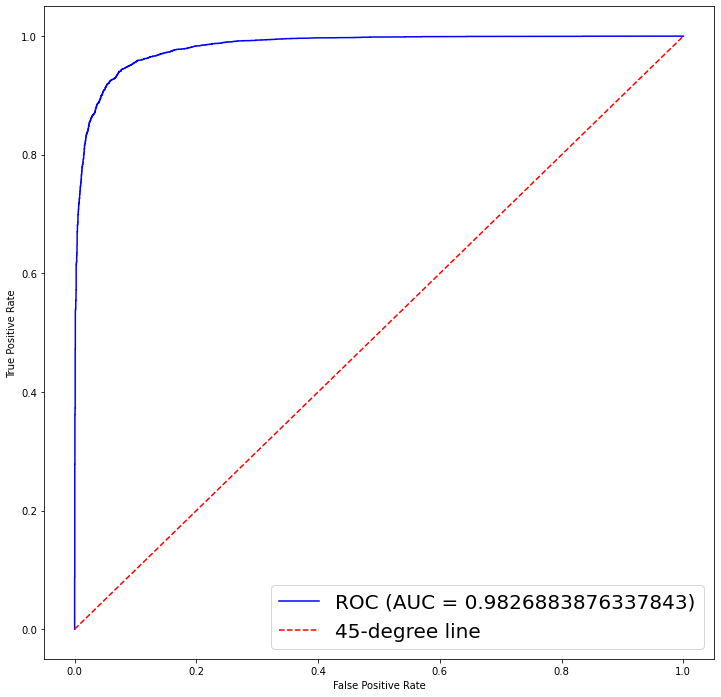

<Figure size 432x288 with 0 Axes>

In [28]:
# graph roc curve for the training set
fpr, tpr, ts = metrics.roc_curve(np.array(y_train), np.array(train_decisions))
plt.figure(figsize=(12,12))
plt.plot(fpr, tpr, color='b', label="ROC (AUC = {})".format(metrics.auc(fpr,tpr)))
plt.plot([0,1],[0,1], color='r', linestyle='--',label='45-degree line')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right', prop={'size':20})
plt.show()
plt.savefig('boosting_roc_auc')

In [29]:
# predict gradient boosting classifier using test values
y_pred_2 = clf.predict(X_test_dums)
pred2 = pd.concat([test['id'],pd.Series(y_pred_2)], axis=1)
pred2 = pred1.rename(columns={0:'Decision'})
pred2.to_csv('boosting_preds.csv',index=False)

<div style = "background-color: #000000; height: 10px; width: 100%">

In [30]:
# Logistic Regression with sklearn
from sklearn.linear_model import LogisticRegression

# 10-fold cross-validation to tune C
cs = [10**(-i) for i in range(12)]
c_accs = np.zeros((len(cs),10,))

kf = KFold(n_splits = 10)
count = 0

start = time.time()

for train_index, validation_index in kf.split(X_train):
    # split training set
    X_t, X_v = X_train_dums.iloc[train_index,:], X_train_dums.iloc[validation_index,:]
    y_t, y_v = y_train.iloc[train_index], y_train.iloc[validation_index]
    for i in range(len(cs)):
        # train on given depth
        log_reg = LogisticRegression(C=cs[i], random_state = rd.randint(0,100))
        log_reg.fit(X_t, y_t)
        pred = log_reg.predict(X_v)

        # get accuracy for this depth on this fold
        c_accs[i][count] = metrics.accuracy_score(pred, y_v)
    
    count += 1

mean_accs = c_accs.mean(axis=1)
std_accs = c_accs.std(axis=1)
max_index = np.argmax(mean_accs)

end = time.time()
print("Time it took to fit tune C (in seconds): " + str(end - start))

print("The maximum mean accuracy I got (" + str(mean_accs[max_index]) +
     ") was with C = " + str(cs[max_index]) + 
      " (std = " + str(std_accs[max_index]) + ").\n")

# save best alpha
c = cs[max_index]

Time it took to fit tune C (in seconds): 4.274823904037476
The maximum mean accuracy I got (0.6796929074500021) was with C = 1 (std = 0.012224808545160223).



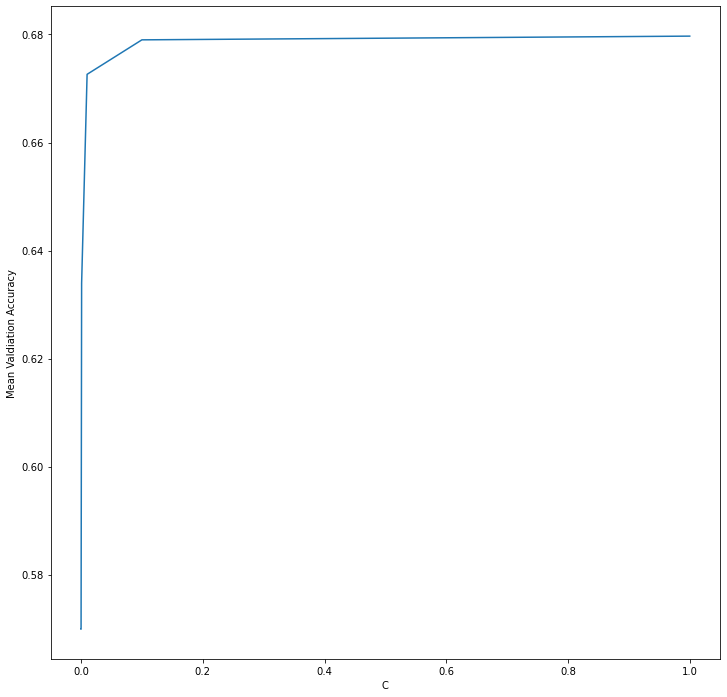

<Figure size 432x288 with 0 Axes>

In [31]:
plt.figure(figsize=(12,12))
plt.plot(cs, mean_accs)
plt.xlabel('C')
plt.ylabel('Mean Valdiation Accuracy')
plt.show()
plt.savefig('logistic_regression_c_tune')

In [32]:
start = time.time()

log_reg = LogisticRegression(C=c, random_state = rd.randint(0,100))
log_reg.fit(X_train_dums, y_train)

end = time.time()
print("Time it took to fit Logistic Regression model (in seconds):" + str(end - start))

train_preds = log_reg.predict(X_train_dums)
print("Accuracy on training set: " + str(metrics.accuracy_score(train_preds, y_train)))

train_probs = log_reg.predict_proba(X_train_dums)
train_decisions = [prob[1] for prob in train_probs]

Time it took to fit Logistic Regression model (in seconds):0.1522068977355957
Accuracy on training set: 0.6828358208955224


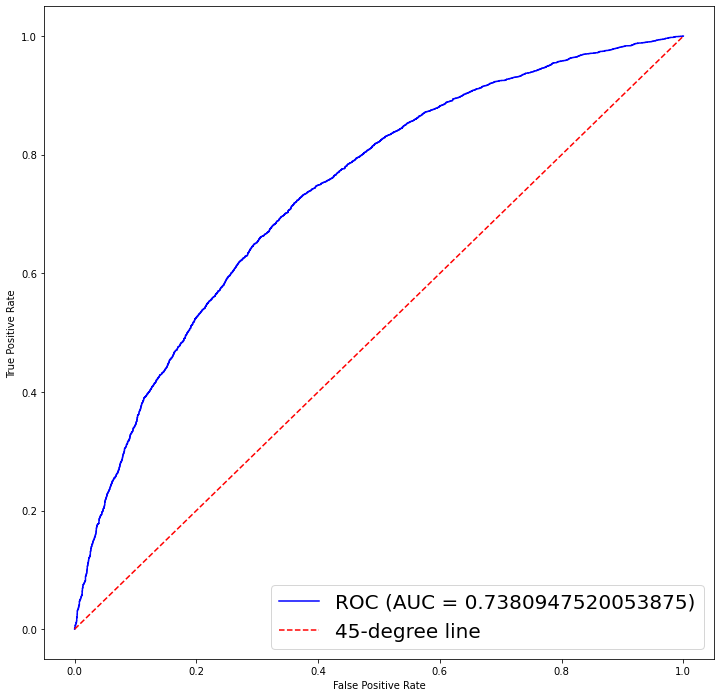

<Figure size 432x288 with 0 Axes>

In [33]:
# graph roc curve for the training set
fpr, tpr, ts = metrics.roc_curve(np.array(y_train), np.array(train_decisions))
plt.figure(figsize=(12,12))
plt.plot(fpr, tpr, color='b', label="ROC (AUC = {})".format(metrics.auc(fpr,tpr)))
plt.plot([0,1],[0,1], color='r', linestyle='--',label='45-degree line')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right', prop={'size':20})
plt.show()
plt.savefig('logistic_regression_roc_auc')

In [34]:
# predict logistic regression using test values
y_pred_3 = log_reg.predict(X_test_dums)
pred3 = pd.concat([test['id'],pd.Series(y_pred_3)], axis=1)
pred3 = pred1.rename(columns={0:'Decision'})
pred3.to_csv('logistic_regression_preds.csv',index=False)